In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  2


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

# Define paths
image_dir = '/kaggle/input/prepared-dataset/train/img'
mask_dir = '/kaggle/input/prepared-dataset/train/mask'

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [self.load_image(img_path) for img_path in batch_image_paths]
        masks = [self.load_image(mask_path, grayscale=True) for mask_path in batch_mask_paths]
        
        return np.array(images), np.array(masks)
    
    def load_image(self, path, grayscale=False):
        img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode='grayscale' if grayscale else 'rgb')
        img = tf.keras.preprocessing.image.img_to_array(img)
        img /= 255.0
        return img

# Define file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])



## Unet model

In [3]:
# Create data generators
train_generator = DataGenerator(image_paths, mask_paths, batch_size=16, image_size=(256, 256))
val_generator = DataGenerator(image_paths, mask_paths, batch_size=16, image_size=(256, 256))


def build_unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


model = build_unet_model(input_shape=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20)
model.save('models/unet_model.h5')

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 664ms/step - accuracy: 0.6250 - loss: 0.6130 - val_accuracy: 0.9480 - val_loss: 0.7120
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.9483 - loss: 0.4193 - val_accuracy: 0.9480 - val_loss: 0.2095
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9470 - loss: 0.1881 - val_accuracy: 0.9480 - val_loss: 0.1768
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9486 - loss: 0.1785 - val_accuracy: 0.9480 - val_loss: 0.1678
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - accuracy: 0.9496 - loss: 0.1598 - val_accuracy: 0.9481 - val_loss: 0.1682
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - accuracy: 0.9472 - loss: 0.1670 - val_accuracy: 0.9481 - val_loss: 0.1582
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9488 - loss: 0.1578 - val_accuracy: 0.9481 - val_loss: 0.1574
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.9494 - loss: 0.1534 - val_accuracy: 0.9484 - val_loss

In [5]:
from tensorflow.keras.models import load_model

model_path= '/kaggle/working/models/unet_model.h5'
# Load the model
model = load_model(model_path)
model_name = os.path.basename(model_path).split('.')[0]

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)

# Print evaluation results
print(f"Model: {model_name}")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Store the results in a dictionary for comparison
results = {
    'model_name': model_name,
    'model_path': model_path,
    'loss': loss,
    'accuracy': accuracy
}

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9643 - loss: 0.0888
Model: unet_model
Loss: 0.0920
Accuracy: 0.9645


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


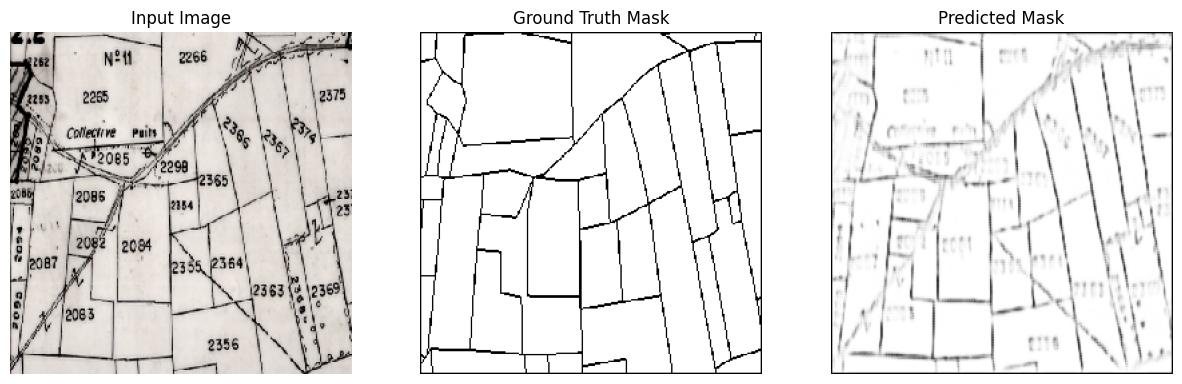

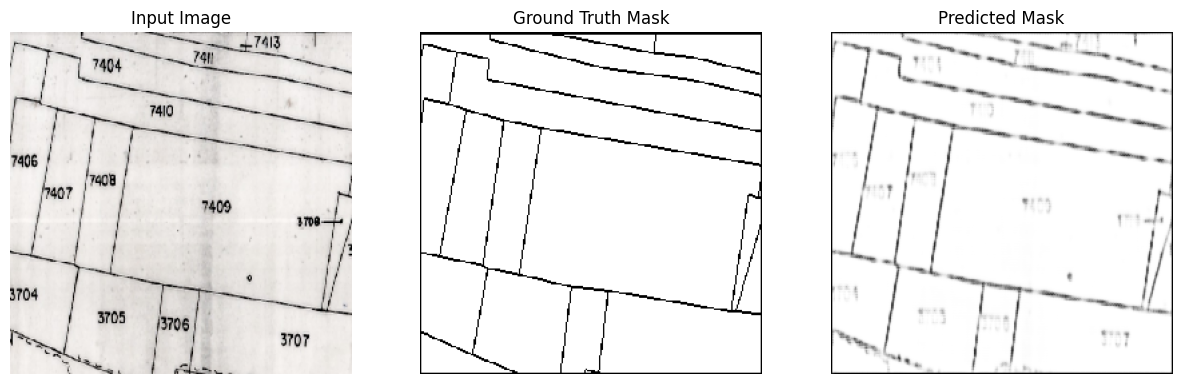

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/test/mask'

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([load_image(img_path) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('models/unet_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=2)

## VGG16

In [7]:
from tensorflow.keras import layers, models, applications
# Create data generators
train_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))
val_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))

def build_vgg16_segmentation_model(input_shape):
    # Load the VGG16 model pre-trained on ImageNet, without the top classification layers
    vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the VGG16 layers
    vgg16.trainable = False

    # Add custom layers for segmentation
    x = vgg16.output
    
    # Upsample to reach (256, 256)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    # Final output layer with sigmoid activation for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=vgg16.input, outputs=outputs)
    return model

# Build and compile the model
model = build_vgg16_segmentation_model(input_shape=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20)
model.save('models/vgg16_model.h5')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 11s/step - accuracy: 0.7092 - loss: 0.6775 - val_accuracy: 0.9480 - val_loss: 0.3997
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - accuracy: 0.9492 - loss: 0.3864 - val_accuracy: 0.9480 - val_loss: 0.3098
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 633ms/step - accuracy: 0.9485 - loss: 0.2624 - val_accuracy: 0.9480 - val_loss: 0.2778
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - accuracy: 0.9469 - loss: 0.2619 - val_accuracy: 0.9486 - val_loss: 0.2110
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 641ms/step - accuracy: 0.9491 - loss: 0.2263 - val_accuracy: 0.9490 - val_loss: 0.2219
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 639ms/step - accuracy: 0.9495 - loss: 0.2052 - val_accuracy: 0.9490 - val_loss: 0.2154
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.9483 - loss: 0.2142 - val_accuracy: 0.9490 - val_loss: 0.1879
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 640ms/step - accuracy: 0.9486

In [8]:
from tensorflow.keras.models import load_model

model_path= '/kaggle/working/models/vgg16_model.h5'
# Load the model
model = load_model(model_path)
model_name = os.path.basename(model_path).split('.')[0]

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)

# Print evaluation results
print(f"Model: {model_name}")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Store the results in a dictionary for comparison
results = {
    'model_name': model_name,
    'model_path': model_path,
    'loss': loss,
    'accuracy': accuracy
}

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.9551 - loss: 0.1637
Model: vgg16_model
Loss: 0.1614
Accuracy: 0.9558


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


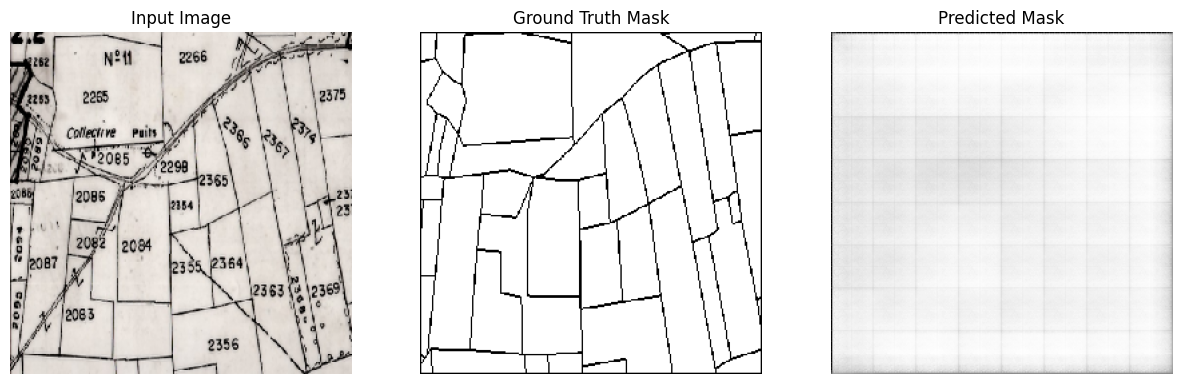

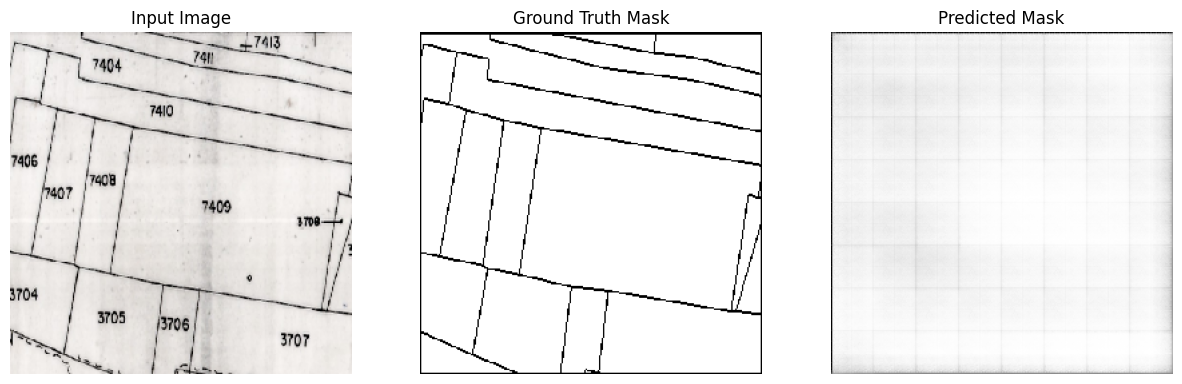

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/test/mask'

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([load_image(img_path) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('models/vgg16_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=2)

## Resnet50

In [10]:
def build_resnet50_segmentation(input_shape):
    # Load the ResNet50 model pre-trained on ImageNet, without the top classification layers
    resnet50 = applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Extract features from the last convolutional block
    x = resnet50.output
    
    # Upsampling to match the original image size
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Final layer to produce the output mask
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    # Ensure the output is resized to match the input shape
    outputs = layers.Resizing(input_shape[0], input_shape[1])(outputs)
    
    # Define the model
    model = models.Model(inputs=resnet50.input, outputs=outputs)
    
    return model

# Define input shape
input_shape = (256, 256, 3)

# Build and compile the model
model = build_resnet50_segmentation(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20)

# Save the model
model.save('models/resnet50_model.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 2:06 63s/step - accuracy: 0.8990 - loss: 0.6758

I0000 00:00:1725404171.599337     108 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 20 bytes spill stores, 20 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 21s/step - accuracy: 0.9264 - loss: 0.5052 - val_accuracy: 0.9441 - val_loss: 0.7121
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step - accuracy: 0.9480 - loss: 0.3098 - val_accuracy: 0.9213 - val_loss: 0.5251
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - accuracy: 0.9480 - loss: 0.2045 - val_accuracy: 0.9481 - val_loss: 0.4047
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - accuracy: 0.9474 - loss: 0.1911 - val_accuracy: 0.9489 - val_loss: 0.3571
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - accuracy: 0.9495 - loss: 0.1823 - val_accuracy: 0.9487 - val_loss: 0.5628
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.9492 - loss: 0.1817 - val_accuracy: 0.9493 - val_loss: 0.3821
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.9496 - loss: 0.1789 - val_accuracy: 0.9499 - val_loss: 0.2252
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.9506 - loss: 0.1711 - val_accuracy: 0.9507 - val_loss: 0.3151
Epo

In [11]:
from tensorflow.keras.models import load_model

model_path= '/kaggle/working/models/resnet50_model.h5'
# Load the model
model = load_model(model_path)
model_name = os.path.basename(model_path).split('.')[0]

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)

# Print evaluation results
print(f"Model: {model_name}")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Store the results in a dictionary for comparison
results = {
    'model_name': model_name,
    'model_path': model_path,
    'loss': loss,
    'accuracy': accuracy
}

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 725ms/step - accuracy: 0.9510 - loss: 0.5770
Model: resnet50_model
Loss: 0.5673
Accuracy: 0.9517


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


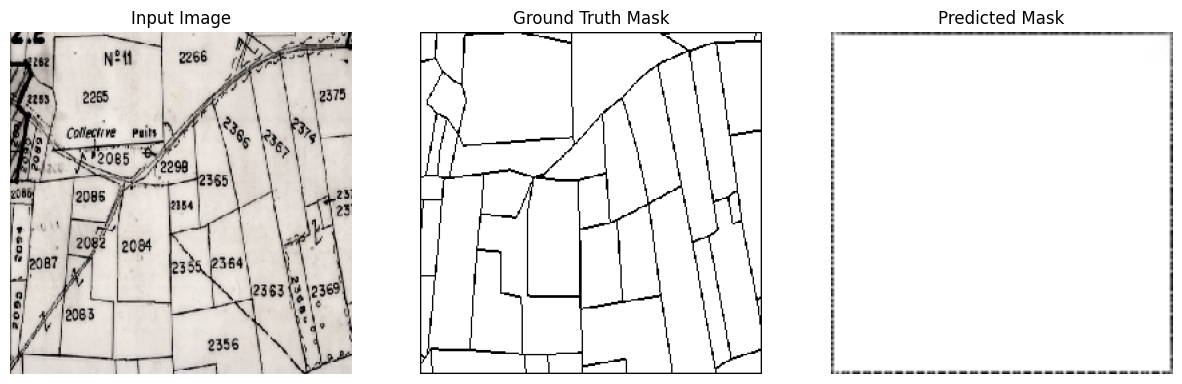

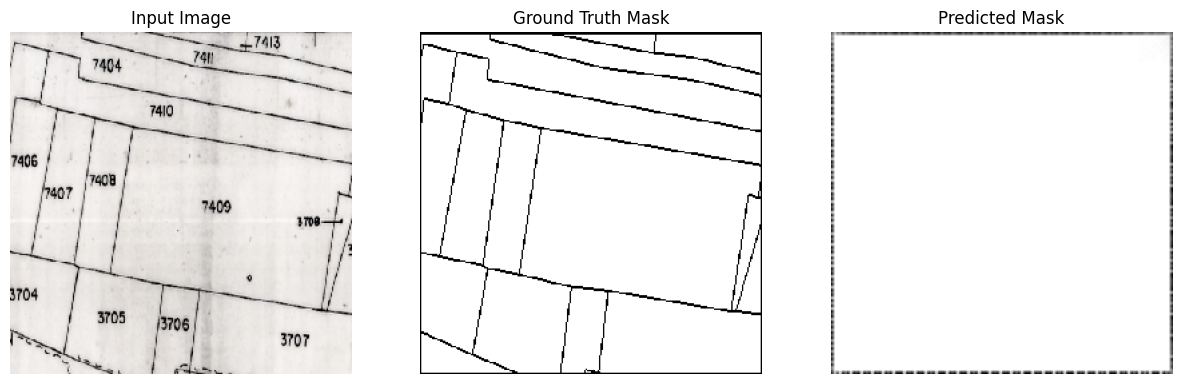

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/test/mask'

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([load_image(img_path) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('models/resnet50_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=2)

## FCN

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [self.load_image(img_path) for img_path in batch_image_paths]
        masks = [self.load_image(mask_path, grayscale=True) for mask_path in batch_mask_paths]
        
        return np.array(images), np.array(masks)
    
    def load_image(self, path, grayscale=False):
        img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode='grayscale' if grayscale else 'rgb')
        img = tf.keras.preprocessing.image.img_to_array(img)
        img /= 255.0
        return img

# Define file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Create data generators

# Adjust batch size and image size
train_generator = DataGenerator(image_paths, mask_paths, batch_size=16, image_size=(128, 128))
val_generator = DataGenerator(image_paths, mask_paths, batch_size=16, image_size=(128, 128))

def build_fcn(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Fully Convolutional layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)

    # Classifying layer
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)

    # Upsampling
    x = Conv2DTranspose(num_classes, (64, 64), strides=(32, 32), padding='same', activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Build and compile the model with the new input shape
model = build_fcn(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20)

# Save the model
model.save('models/fcn_model.h5')

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 395ms/step - accuracy: 0.5545 - loss: 0.7091 - val_accuracy: 0.6284 - val_loss: 0.6775
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.7909 - loss: 0.6840 - val_accuracy: 0.8627 - val_loss: 0.6846
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.8010 - loss: 0.6636 - val_accuracy: 0.7301 - val_loss: 0.5849
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.7502 - loss: 0.5363 - val_accuracy: 0.8146 - val_loss: 0.4193
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.8322 - loss: 0.4008 - val_accuracy: 0.8837 - val_loss: 0.3213
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.8948 - loss: 0.3038 - val_accuracy: 0.9233 - val_loss: 0.2574
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.9304 - loss: 0.2439 - val_accuracy: 0.9487 - val_loss: 0.2187
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.9528 - loss: 0.2094 - val_accuracy: 0.9592 - val_loss

In [16]:
from tensorflow.keras.models import load_model

model_path= '/kaggle/working/models/fcn_model.h5'
# Load the model
model = load_model(model_path)
model_name = os.path.basename(model_path).split('.')[0]

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)

# Print evaluation results
print(f"Model: {model_name}")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9620 - loss: 0.6486
Model: fcn_model
Loss: 0.6485
Accuracy: 0.9627


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


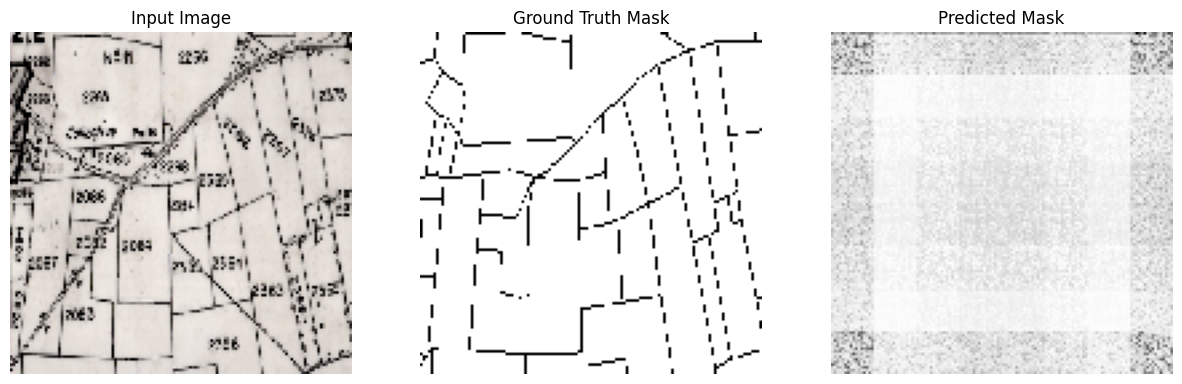

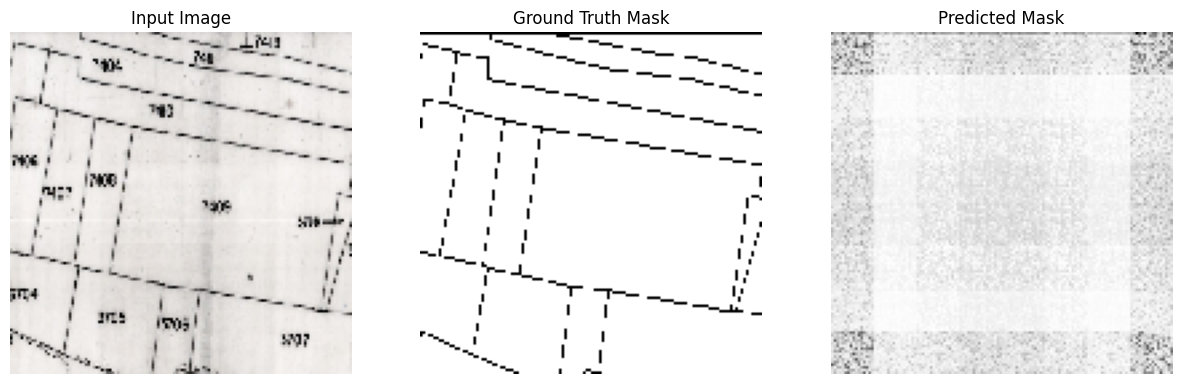

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/test/mask'

# Load images and masks
def load_image(image_path, target_size=(128, 128), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([load_image(img_path) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('models/fcn_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=2)

## HED

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, Input
import numpy as np
import os

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [self.load_image(img_path) for img_path in batch_image_paths]
        masks = [self.load_image(mask_path, grayscale=True) for mask_path in batch_mask_paths]
        
        return np.array(images), np.array(masks)
    
    def load_image(self, path, grayscale=False):
        img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode='grayscale' if grayscale else 'rgb')
        img = tf.keras.preprocessing.image.img_to_array(img)
        img /= 255.0
        return img

# Define file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Create data generators
train_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))
val_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))



def side_output(x, factor):
    return Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

def hed(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    p1 = MaxPooling2D((2, 2))(x1)

    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    p2 = MaxPooling2D((2, 2))(x2)

    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    p3 = MaxPooling2D((2, 2))(x3)

    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    p4 = MaxPooling2D((2, 2))(x4)

    x5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same')(x5)
    x5 = Conv2D(512, (3, 3), activation='relu', padding='same')(x5)

    # Side outputs
    side1 = side_output(x1, factor=1)
    side2 = side_output(x2, factor=2)
    side3 = side_output(x3, factor=4)
    side4 = side_output(x4, factor=8)
    side5 = side_output(x5, factor=16)

    # Upsample side outputs to the original image size
    side1_up = UpSampling2D(size=(1, 1))(side1)
    side2_up = UpSampling2D(size=(2, 2))(side2)
    side3_up = UpSampling2D(size=(4, 4))(side3)
    side4_up = UpSampling2D(size=(8, 8))(side4)
    side5_up = UpSampling2D(size=(16, 16))(side5)

    # Concatenate side outputs
    fuse = Add()([side1_up, side2_up, side3_up, side4_up, side5_up])
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(fuse)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build model
input_shape = (256, 256, 3)
model = hed(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Training
model.fit(train_generator, validation_data=val_generator, epochs=20)

# Save the model
model.save('models/hed_model.h5')

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 22s/step - accuracy: 0.9476 - loss: 0.2114 - val_accuracy: 0.9480 - val_loss: 0.2125
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.9469 - loss: 0.2139 - val_accuracy: 0.9480 - val_loss: 0.2022
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.9473 - loss: 0.2040 - val_accuracy: 0.9480 - val_loss: 0.1990
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 831ms/step - accuracy: 0.9476 - loss: 0.2007 - val_accuracy: 0.9480 - val_loss: 0.1995
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step - accuracy: 0.9473 - loss: 0.1988 - val_accuracy: 0.9480 - val_loss: 0.1916
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - accuracy: 0.9492 - loss: 0.1872 - val_accuracy: 0.9480 - val_loss: 0.1840
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - accuracy: 0.9469 - loss: 0.1844 - val_accuracy: 0.9480 - val_loss: 0.1746
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.9488 - loss: 0.1748 - val_accuracy: 0.9480 - val_loss: 

In [17]:
from tensorflow.keras.models import load_model

model_path= '/kaggle/working/models/hed_model.h5'
# Load the model
model = load_model(model_path)
model_name = os.path.basename(model_path).split('.')[0]

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)

# Print evaluation results
print(f"Model: {model_name}")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Store the results in a dictionary for comparison
results = {
    'model_name': model_name,
    'model_path': model_path,
    'loss': loss,
    'accuracy': accuracy
}

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.9473 - loss: 0.1449
Model: hed_model
Loss: 0.1444
Accuracy: 0.9480


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


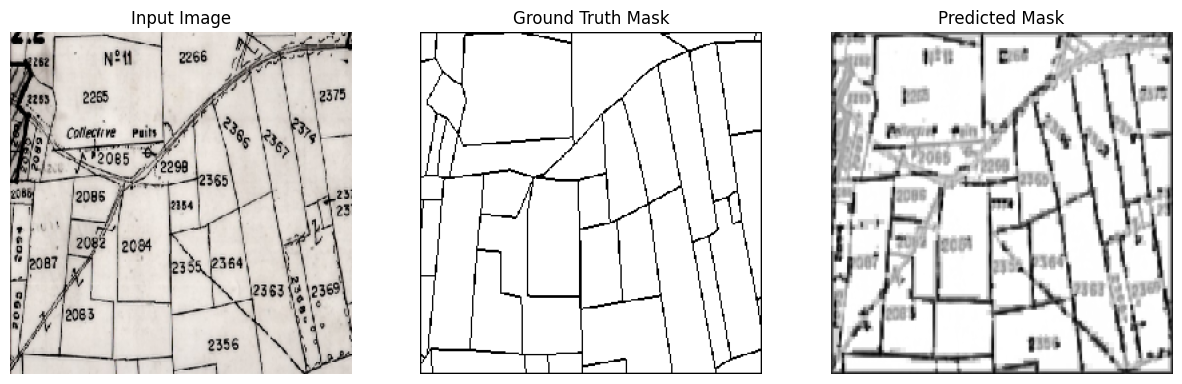

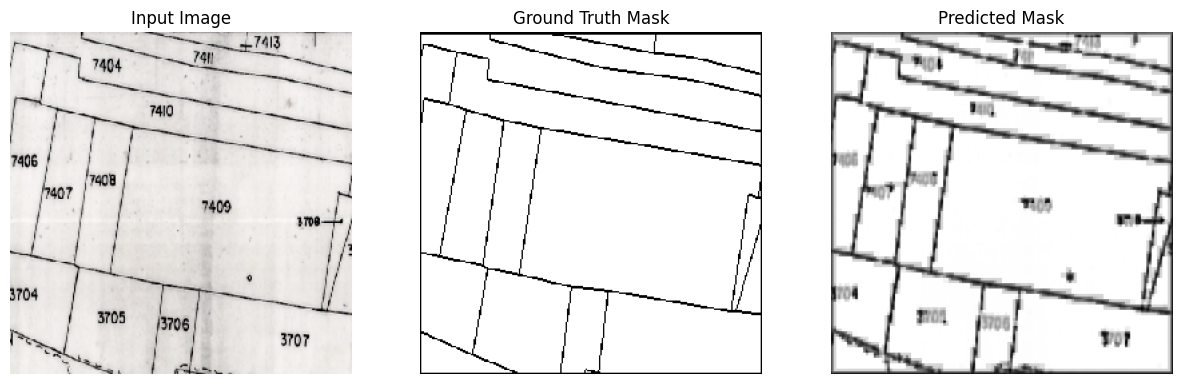

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/test/mask'

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([load_image(img_path) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('models/hed_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=2)

## DeeplabV3

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os



class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]

        images = [self.load_image(img_path) for img_path in batch_image_paths]
        masks = [self.load_image(mask_path, grayscale=True) for mask_path in batch_mask_paths]

        return np.array(images), np.array(masks)

    def load_image(self, path, grayscale=False):
        img = tf.keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode='grayscale' if grayscale else 'rgb')
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img.astype('float32') / 255.0
        return img


# Define file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Create data generators
train_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))
val_generator = DataGenerator(image_paths, mask_paths, batch_size=32, image_size=(256, 256))

import tensorflow as tf


def deeplabv3(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution and downsampling
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Encoder: Downsampling
    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # ASPP Module
    b0 = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.ReLU()(b0)
    
    b1 = layers.Conv2D(256, 3, dilation_rate=6, padding='same', use_bias=False)(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)
    
    b2 = layers.Conv2D(256, 3, dilation_rate=12, padding='same', use_bias=False)(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)
    
    b3 = layers.Conv2D(256, 3, dilation_rate=18, padding='same', use_bias=False)(x)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)
    
    x = layers.Concatenate()([b0, b1, b2, b3])
    
    x = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Upsample to match the input size
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = layers.Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

model = deeplabv3(input_shape=(256, 256, 3), num_classes=1)

# Compile model with gradient clipping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=20)

# Save the model
model.save('models/deeplabv3_model.h5')

Epoch 1/20


2024-09-03 23:10:38.033115: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng5{} for conv (f32[4608,128,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[4608,256,6,6]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-03 23:10:38.076859: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.043847437s
Trying algorithm eng5{} for conv (f32[4608,128,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[4608,256,6,6]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_r

3/3 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - accuracy: 0.2238 - loss: 1.0172 - val_accuracy: 0.1700 - val_loss: 0.6987
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3164 - loss: 0.9381 - val_accuracy: 0.2167 - val_loss: 0.6973
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3417 - loss: 0.8841 - val_accuracy: 0.4701 - val_loss: 0.6929
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3715 - loss: 0.8410 - val_accuracy: 0.9467 - val_loss: 0.6775
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4485 - loss: 0.7860 - val_accuracy: 0.9480 - val_loss: 0.6562
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5372 - loss: 0.7393 - val_accuracy: 0.9480 - val_loss: 0.6326
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6170 - loss: 0.6877 - val_accuracy: 0.9480 - val_loss: 0.6100
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6733 - loss: 0.6453 - val_accuracy: 0.9480 - val_loss: 0.5893
Epoch 9/20
3/3 ━━━━━━━━━━

In [20]:
from tensorflow.keras.models import load_model

model_path= '/kaggle/working/models/deeplabv3_model.h5'
# Load the model
model = load_model(model_path)
model_name = os.path.basename(model_path).split('.')[0]

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)

# Print evaluation results
print(f"Model: {model_name}")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Store the results in a dictionary for comparison
results = {
    'model_name': model_name,
    'model_path': model_path,
    'loss': loss,
    'accuracy': accuracy
}

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.9473 - loss: 0.3609
Model: deeplabv3_model
Loss: 0.3599
Accuracy: 0.9480


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


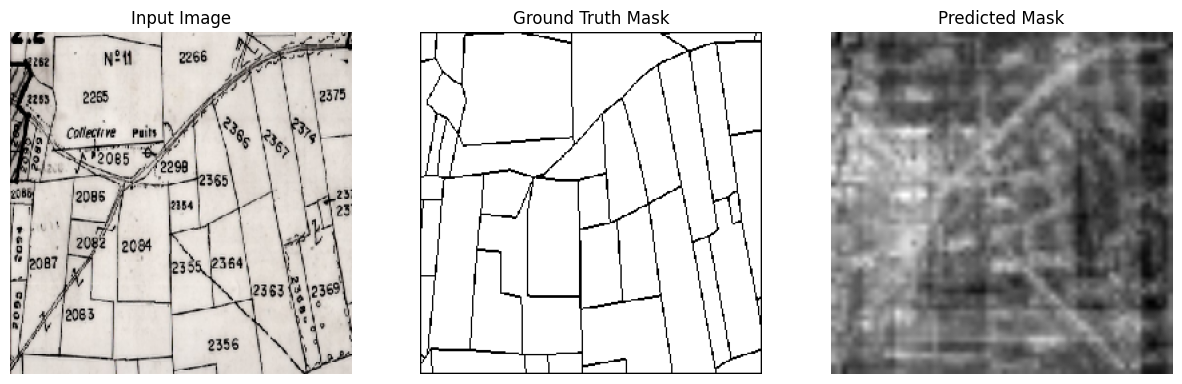

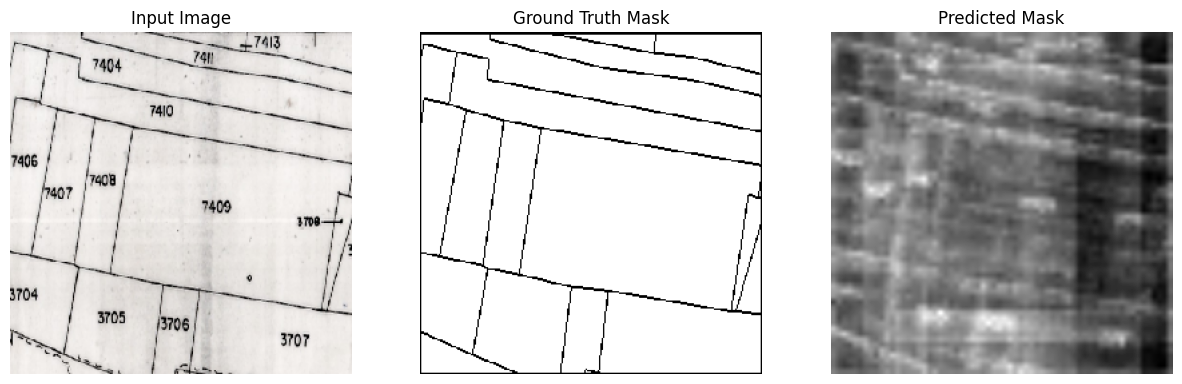

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define paths to your testing dataset
test_image_dir = '/kaggle/input/prepared-dataset/test/img'
test_mask_dir = '/kaggle/input/prepared-dataset/test/mask'

# Load images and masks
def load_image(image_path, target_size=(256, 256), grayscale=False):
    img = image.load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img = image.img_to_array(img)
    img /= 255.0
    return img

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir)])

test_images = np.array([load_image(img_path) for img_path in test_image_paths])
test_masks = np.array([load_image(mask_path, grayscale=True) for mask_path in test_mask_paths])

# Load your trained model
model = tf.keras.models.load_model('models/deeplabv3_model.h5')

# Make predictions
predictions = model.predict(test_images)

# Display results
def display_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i])
        axs[0].set_title('Input Image')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i].squeeze(), cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(predictions[i].squeeze(), cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

# Display results for the first few images
display_results(test_images, test_masks, predictions, num_images=2)